# 1. IMPORTACOES

## 1.1 Funcoes de Ajuda

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import inflection
import math
import datetime

from matplotlib            import pyplot as plt
from matplotlib            import gridspec as gs
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from scipy                 import stats as ss

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


## 1.2 Carregamento dos Dados

In [2]:
df_sales_raw = pd.read_csv( 'datas/train.csv' , low_memory=False )
df_store_raw = pd.read_csv( 'datas/store.csv' , low_memory=False )

In [3]:
# Juntar os dois dataframes
df_raw = pd.merge( df_sales_raw , df_store_raw , how='left' , on='Store')

# 2. DESCRICAO DOS DADOS

## 2.1 Renomeacao das Colunas

In [4]:
# Extracao das descricoes das colunas
df1 = df_raw.copy()
cols_old = df1.columns

In [5]:
# Alteracao dos nomes das colunas, incluindo um '_'
snakecase = lambda x : inflection.underscore(x)
cols_new = list( map( snakecase, cols_old ) )
df1.columns = cols_new

## 2.2 Dimensoes dos Dados

In [6]:
print( "Numero de linhas: {}".format(df1.shape[0]) )
print( "Numero de colunas: {}".format(df1.shape[1]) )

Numero de linhas: 1017209
Numero de colunas: 18


## 2.3 Tipos dos Dados

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Verificacao e Tratamento dos NAs

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [9]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x : 100000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda w: w['date'].month if math.isnan( w['competition_open_since_month'] ) else w['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda w: w['date'].year if math.isnan( w['competition_open_since_year'] ) else w['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda w: w['date'].week if math.isnan( w['promo2_since_week'] ) else w['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda w: w['date'].year if math.isnan( w['promo2_since_year'] ) else w['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda y: 0 if y['promo_interval']==0 else 1 if y['month_map'] in y['promo_interval'].split(',') else 0 , axis=1 )

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.5 Alteracao dos Tipos de Dados

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 3. Estatistica Descritiva

In [13]:
num_attributes = df1.select_dtypes( include=['int32','int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int32','int64','float64','datetime64[ns]'] )

## 3.1 Atributos Numericos

In [14]:
# Tendencias Centrais
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Medidas de Dispersao
d1 = pd.DataFrame( num_attributes.apply(np.std) ).T
d2 = pd.DataFrame( num_attributes.apply(min) ).T
d3 = pd.DataFrame( num_attributes.apply(max) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min()) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis()) ).T

# Uniao dos dataframes
metrics = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
metrics.columns = ['atributos','min','max','interv','media','mediana','devpad','skew','curtosis']

In [15]:
metrics

,atributos,min,max,interv,media,mediana,devpad,skew,curtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 3.2 Atributos Categoricos

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

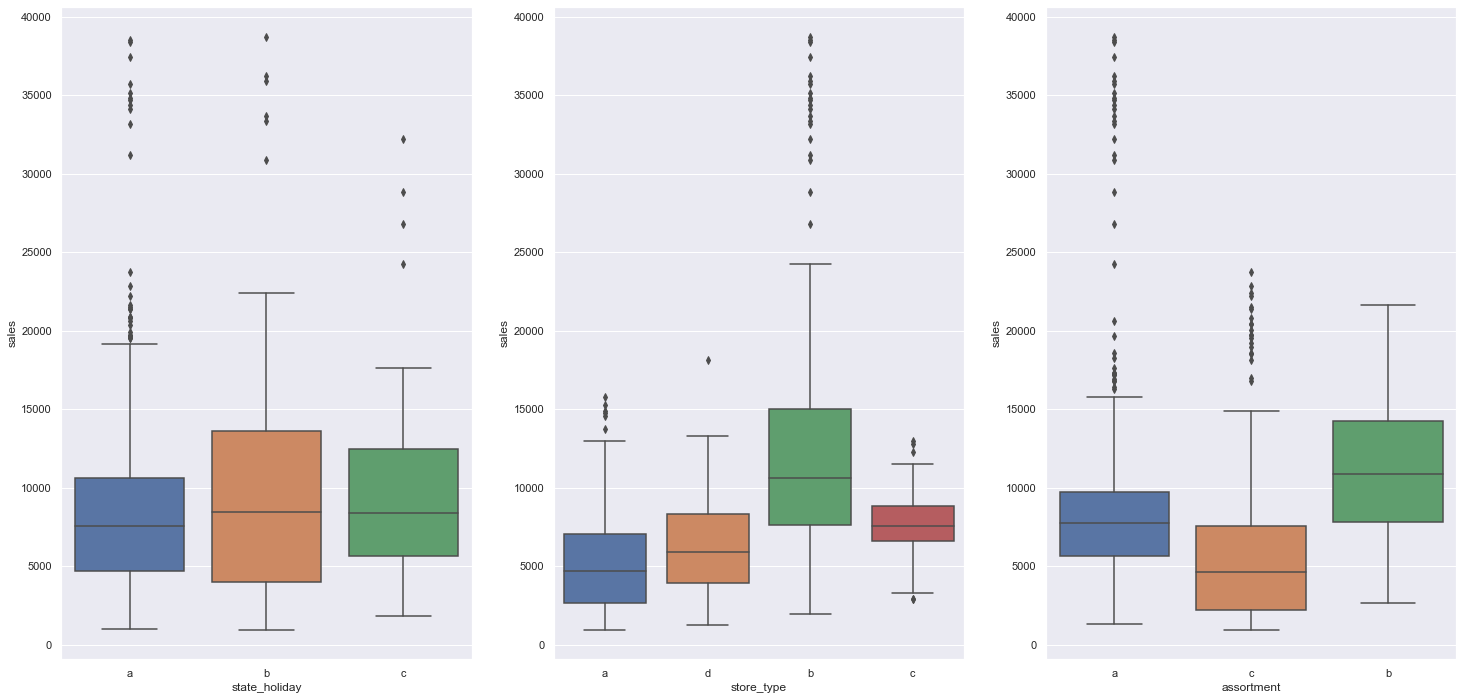

In [17]:
aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday' ,y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot( x='store_type' ,y='sales', data=aux1 )

plt.subplot(1,3,3)
sns.boxplot( x='assortment' ,y='sales', data=aux1 )

# 4. ENGENHARIA DE CARACTERISTICAS (Feature Engineering)

## 4.1 Mapa Mental das Hipoteses

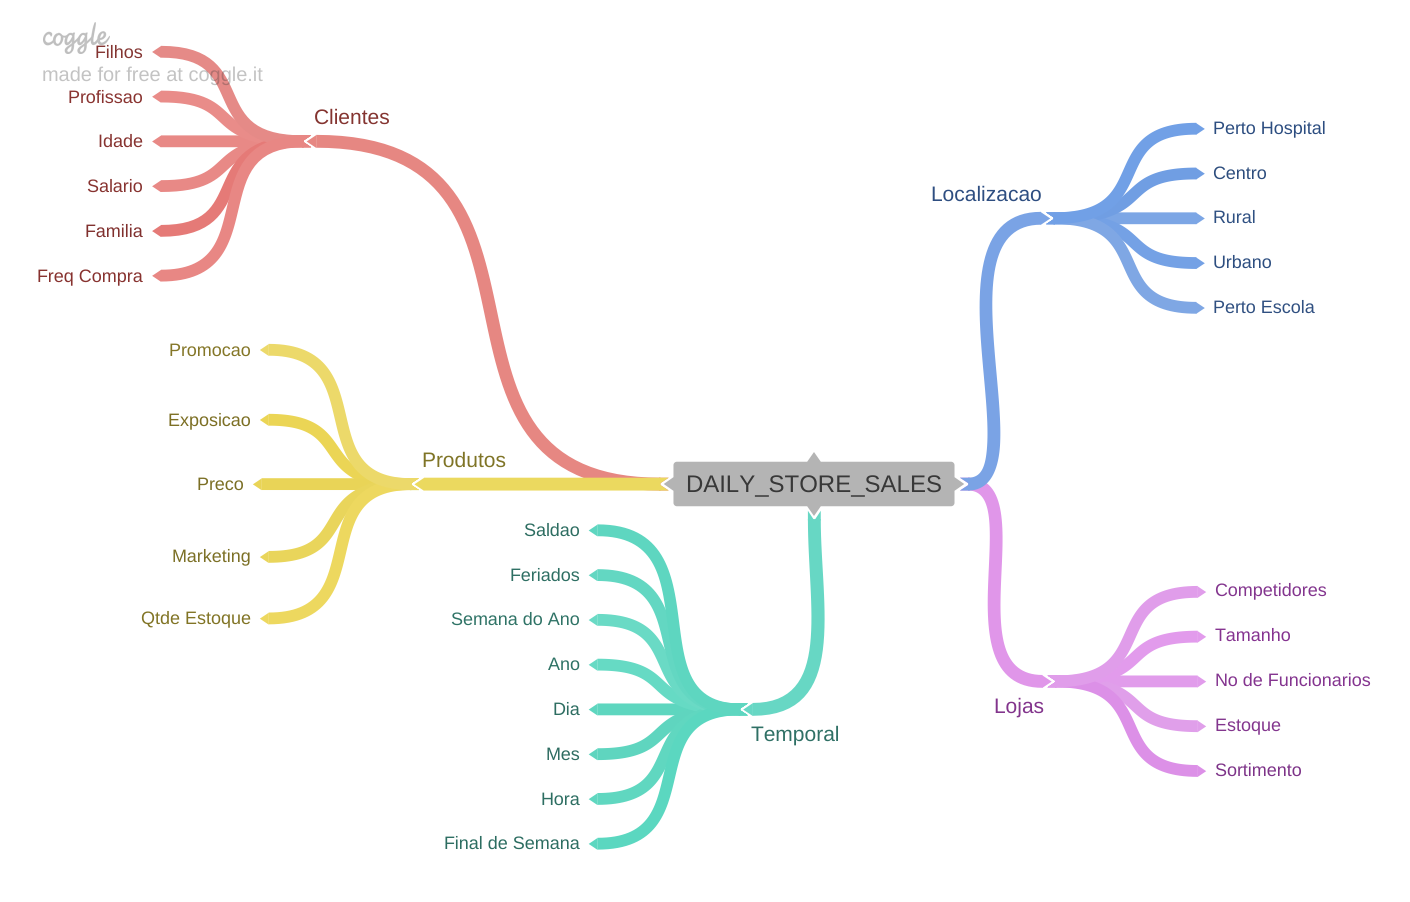

In [18]:
Image( 'datas\daily_store_sales.png')

## 4.2 Criacao das Hipoteses

### 4.2.1 Hipoteses do item Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.</br>
**2.** Lojas com maior estoque deveriam vender mais.</br>
**3.** Lojas com maior porte deveriam vender mais.</br>
**4.** Lojas com maior sortimento deveriam vender mais.</br>
**5.** Lojas com competidores mais proximos deveriam vender menos.</br>
**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 4.2.2 Hipoteses do item Produto

**1.** Lojas com produtos com preco menor deveriam vender mais.</br>
**2.** Lojas com promocoes mais agressivas deveriam vender mais.</br>
**3.** Lojas com promocoes ativas por mais tempo deveriam vender mais.</br>
**4.** Lojas com mais dias de promocao deveriam vender mais.</br>
**5.** Lojas com promocoes mais consecutivas deveriam vender mais.

### 4.2.3 Hipoteses do item Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.</br>
**2.** Lojas deveriam vender mais ao longo dos anos.</br>
**3.** Lojas deveriam vender mais no segundo semestre do ano.</br>
**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.</br>
**5.** Lojas deveriam vender menos aos finais-de-semana.</br>
**6.** Lojas deveriam vender menos durante os feriados escolares.

## 4.3 Lista Final de Hipoteses

**LOJAS**</br>
**1.** Lojas com maior sortimento deveriam vender mais.</br>
**2.** Lojas com competidores mais proximos deveriam vender menos.</br>
**3.** Lojas com competidores a mais tempo deveriam vender mais.

**PRODUTOS**</br>
**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.</br>
**5.** Lojas com mais dias de promocao deveriam vender mais.</br>
**6.** Lojas com promocoes mais consecutivas deveriam vender mais.

**TEMPO**</br>
**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.</br>
**8.** Lojas deveriam vender mais ao longo dos anos.</br>
**9.** Lojas deveriam vender mais no segundo semestre do ano.</br>
**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.</br>
**11.** Lojas deveriam vender menos aos finais-de-semana.</br>
**12.** Lojas deveriam vender menos durante os feriados escolares.

## 4.4 Feature Engineering

In [19]:
df2 = df1.copy()

In [20]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
#df1['month'] = df1['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year-Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition Since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'] , day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'])/30 ).apply(lambda w: w.days ).astype(int)

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1' , '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'])/7 ).apply(lambda y: y.days ).astype(int)

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 5. FILTRAGEM DE VARIAVEIS

In [22]:
df3 = df2.copy()

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1. Filtragem das Linhas

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 5.2 Selecao das Colunas

In [25]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 6. ANALISE EXPLORATORIA DOS DADOS (EDA)

In [26]:
df4 = df3.copy()

## 6.1 Analise Univariada

### 6.1.1 Variavel-Resposta

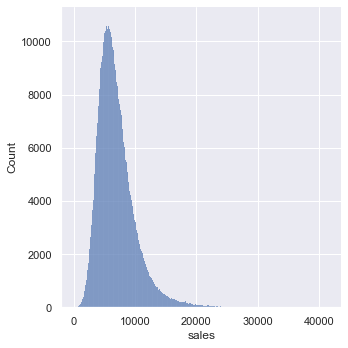

In [27]:
sns.displot( df4['sales'], kde=False );

### 6.1.2 Variaveis Numericas

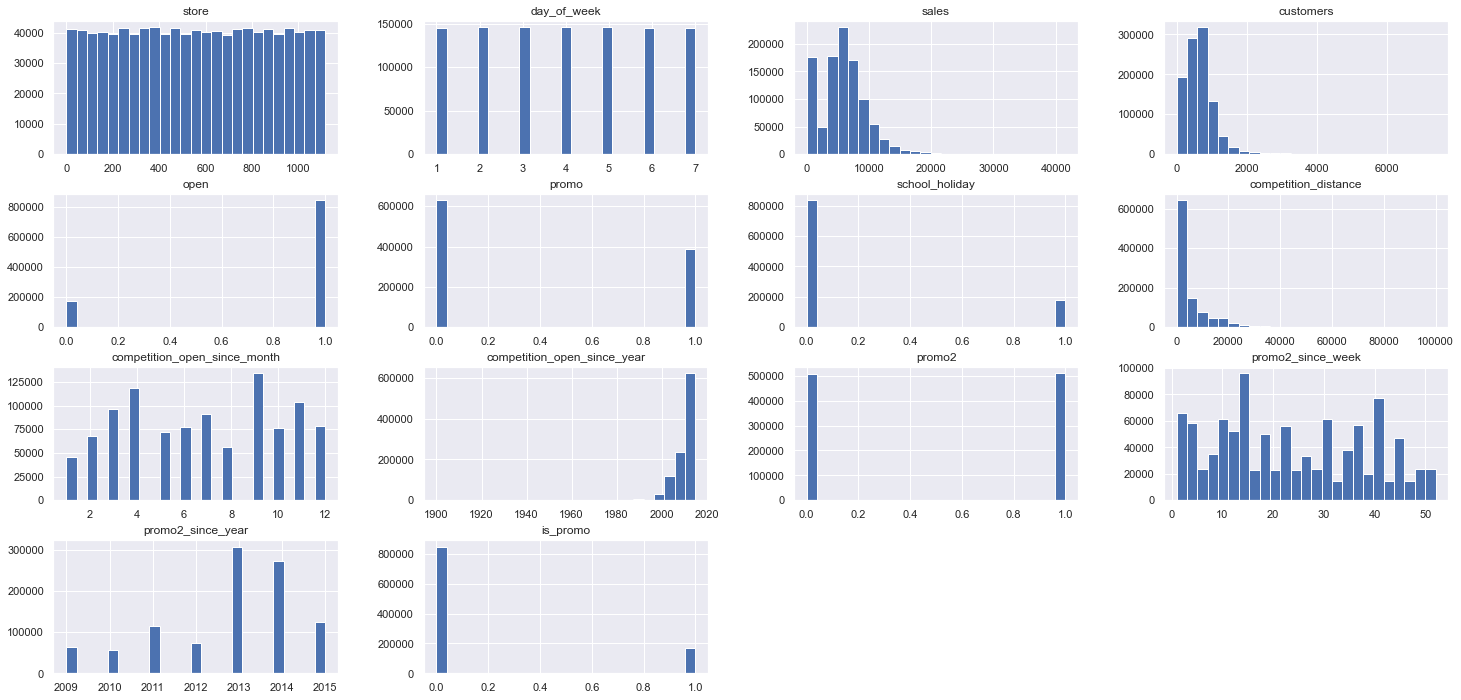

In [28]:
num_attributes.hist( bins=25 );

### 6.1.3 Variaveis Categoricas

C:\Users\renat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\renat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\renat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

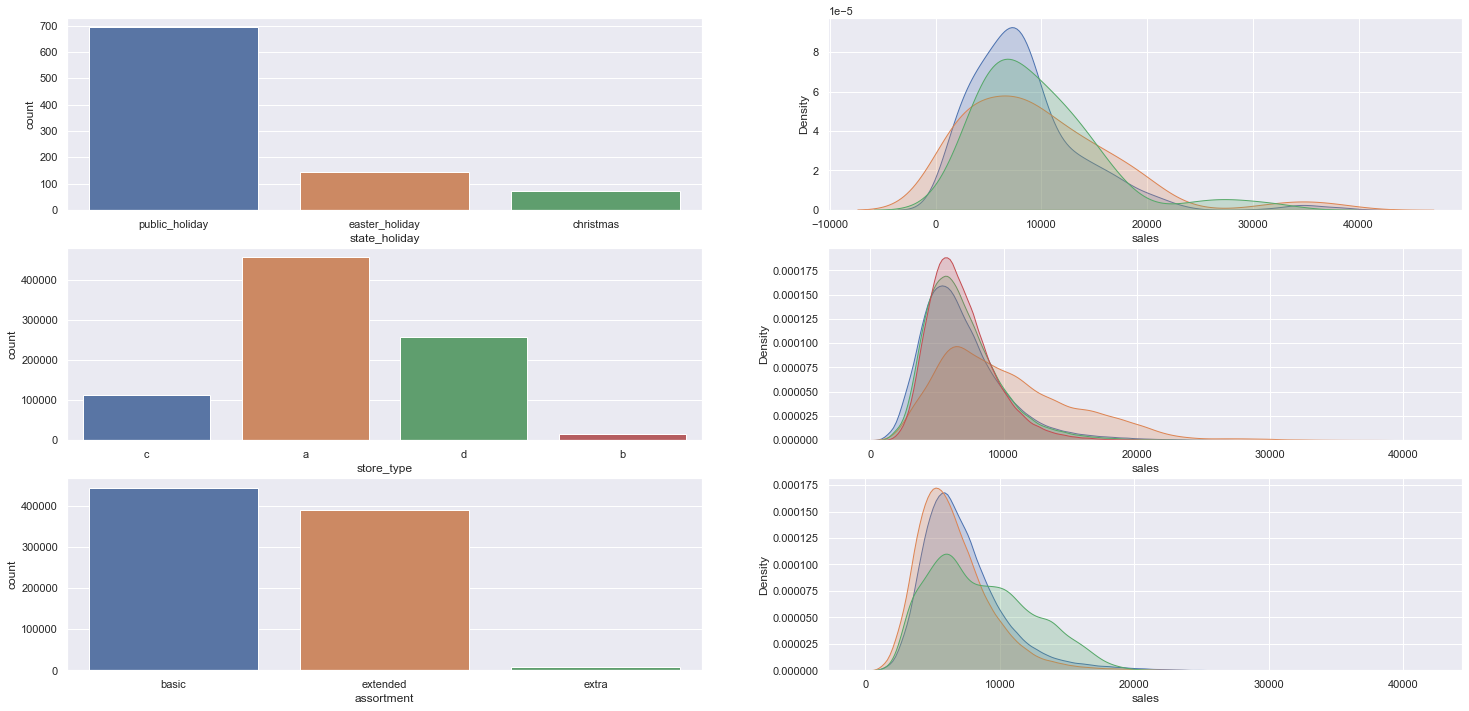

In [29]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 6.2 Analise Bivariada

### 6.2.1 [H1] Lojas com maior sortimentos deveriam vender mais.
#### (FALSA) Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

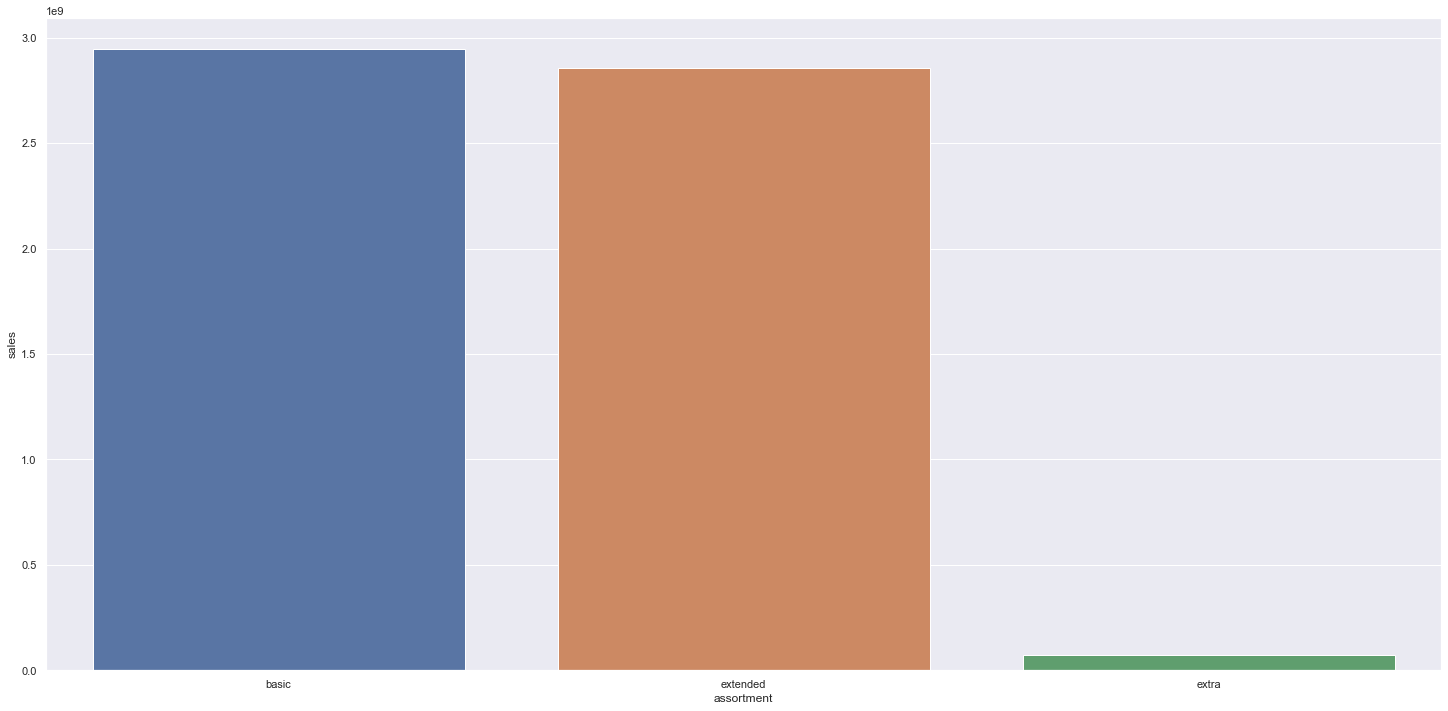

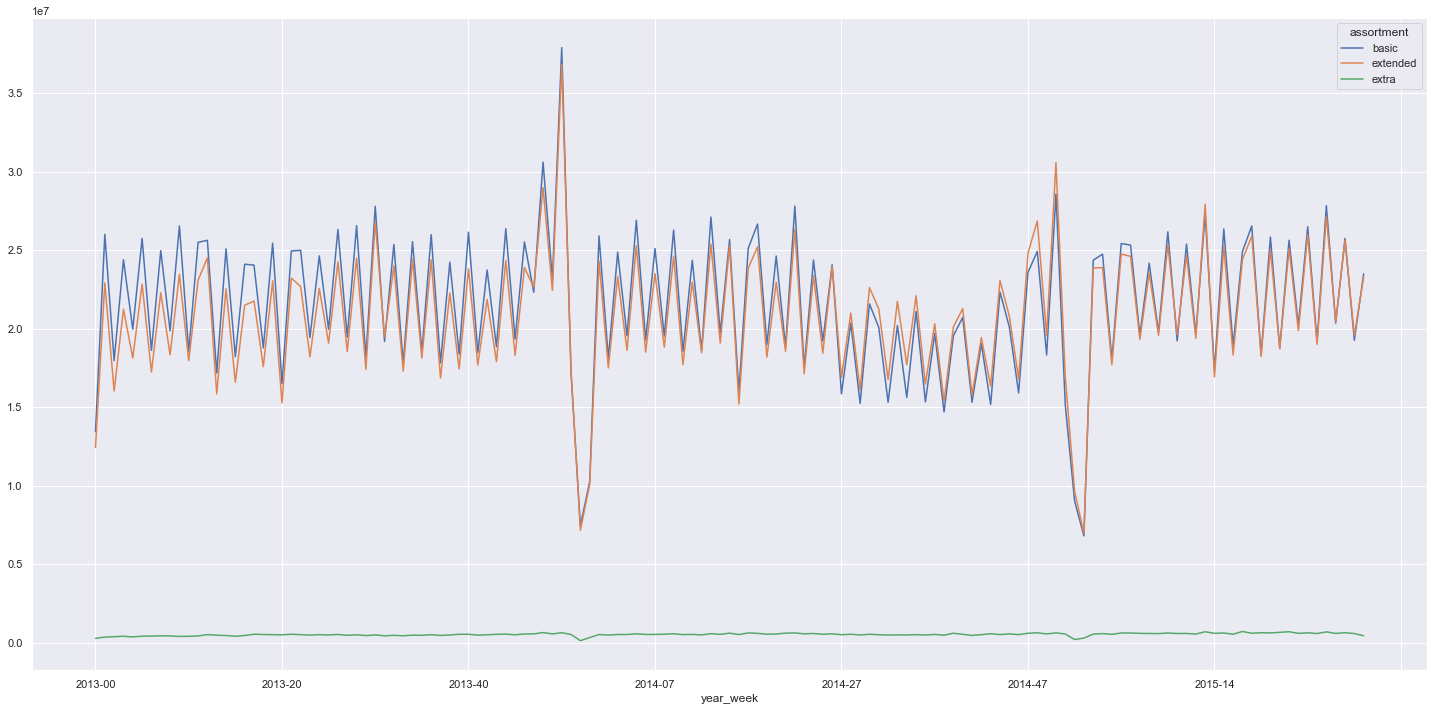

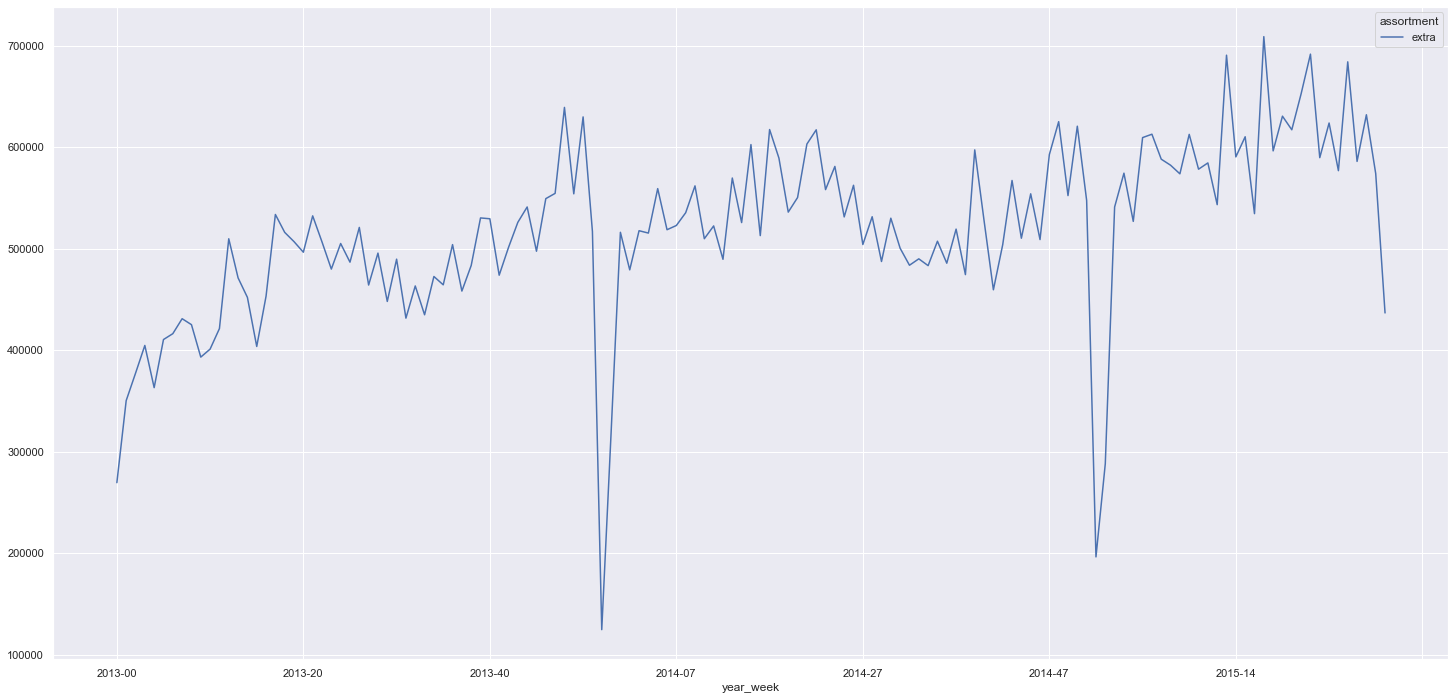

In [30]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### 6.2.2 [H2] Lojas com competidores mais próximos deveriam vender menos.
#### (FALSA) Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

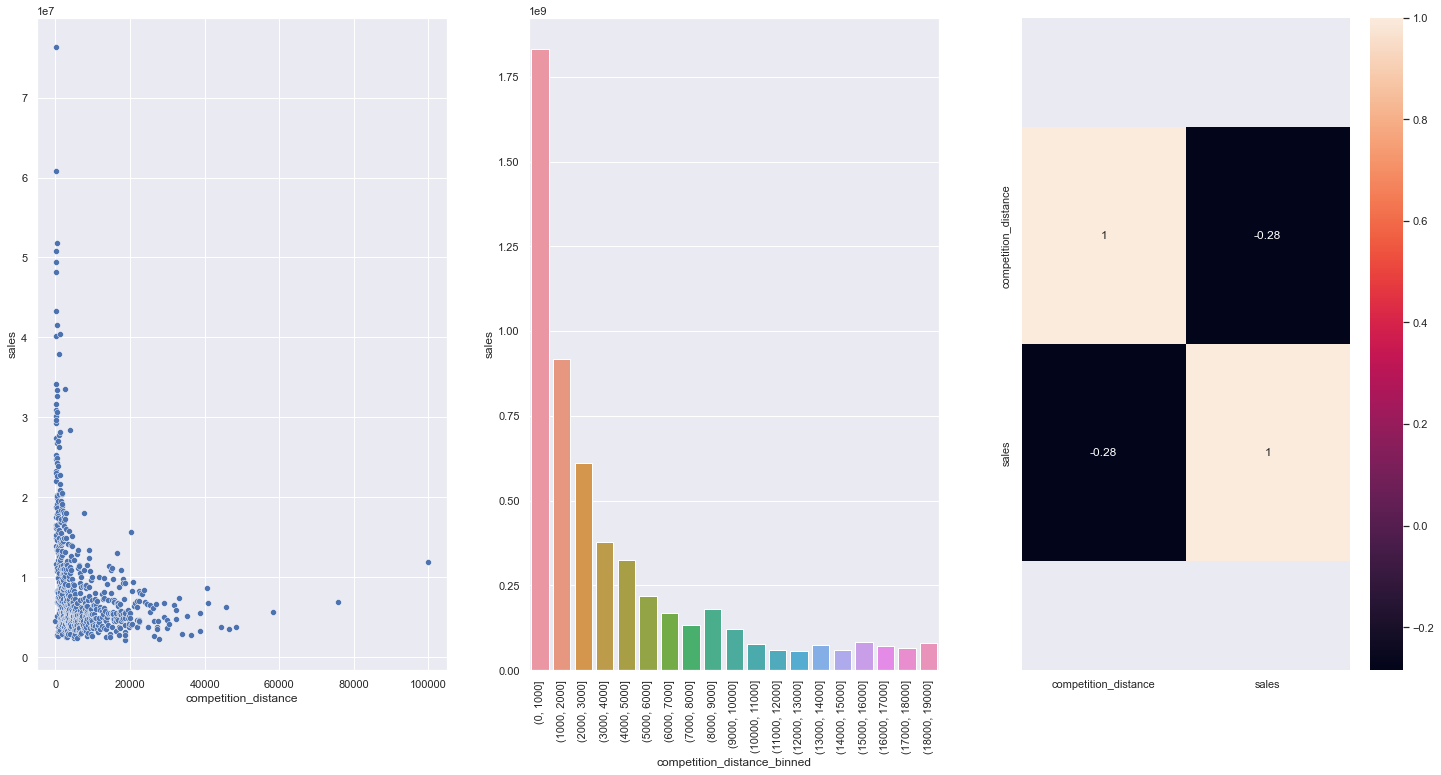

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### 6.2.3 [H3] Lojas com competidores à mais tempo deveriam vendem mais.
#### (FALSA) Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

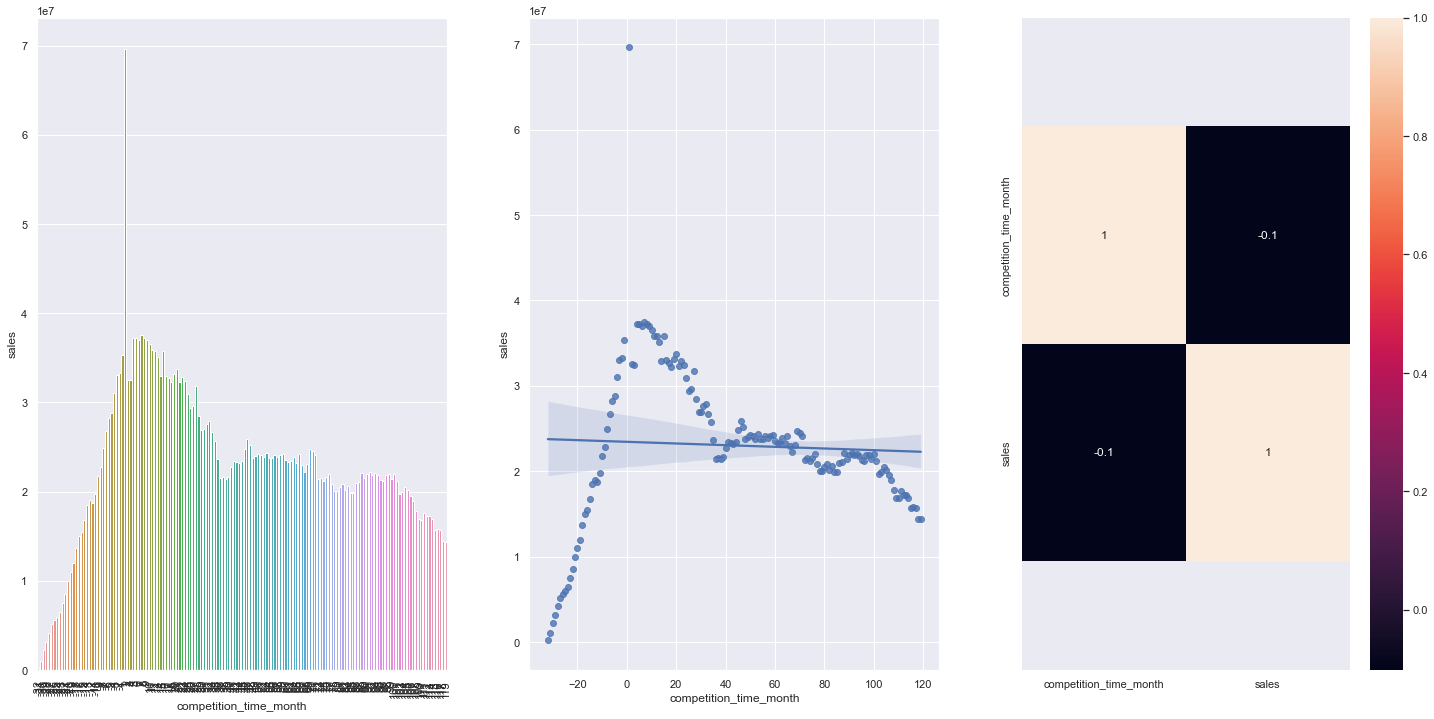

In [32]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### 6.2.4 [H4] Lojas com promoções ativas por mais tempo deveriam vender mais.
#### (FALSA) Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

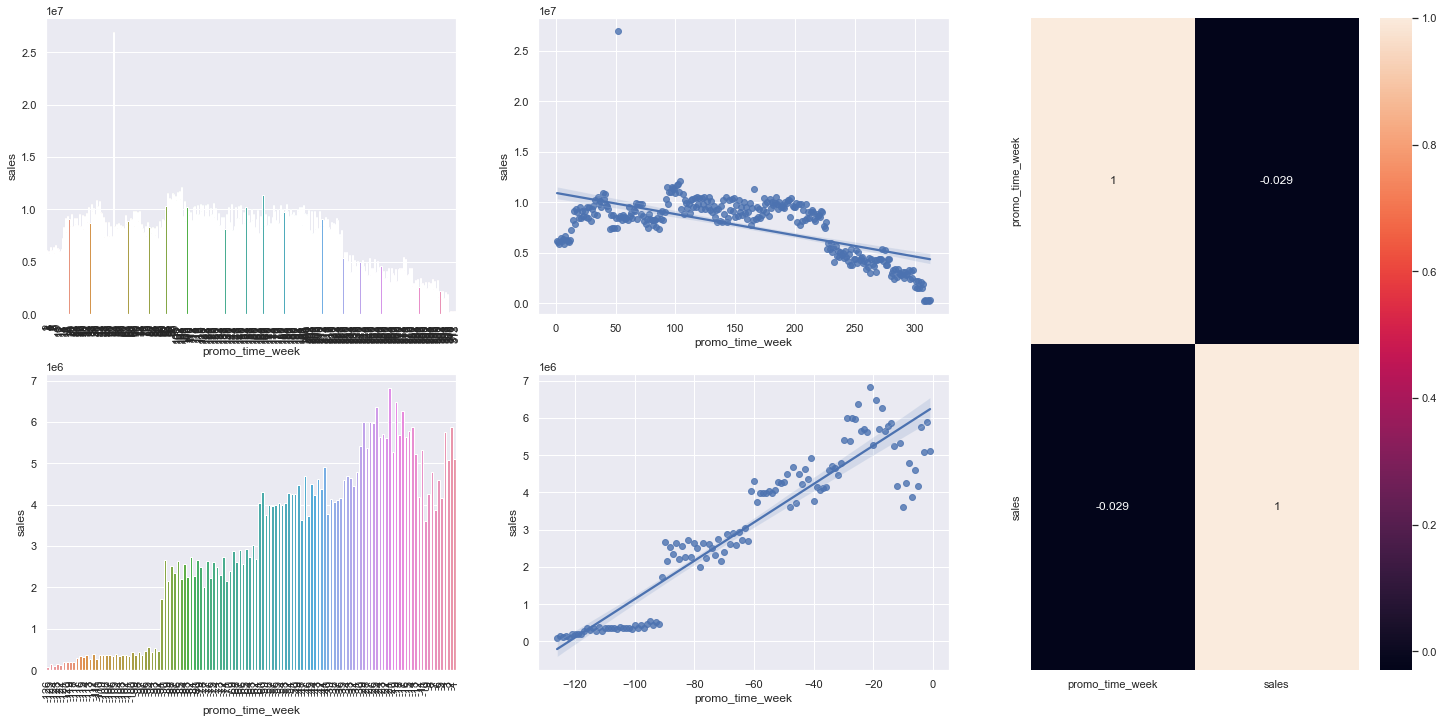

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = gs.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 6.2.5 [H5] Lojas com mais promoções consecutivas deveriam vender mais.
#### (FALSA) Lojas com mais promocoes consecutivas vendem menos.

In [34]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


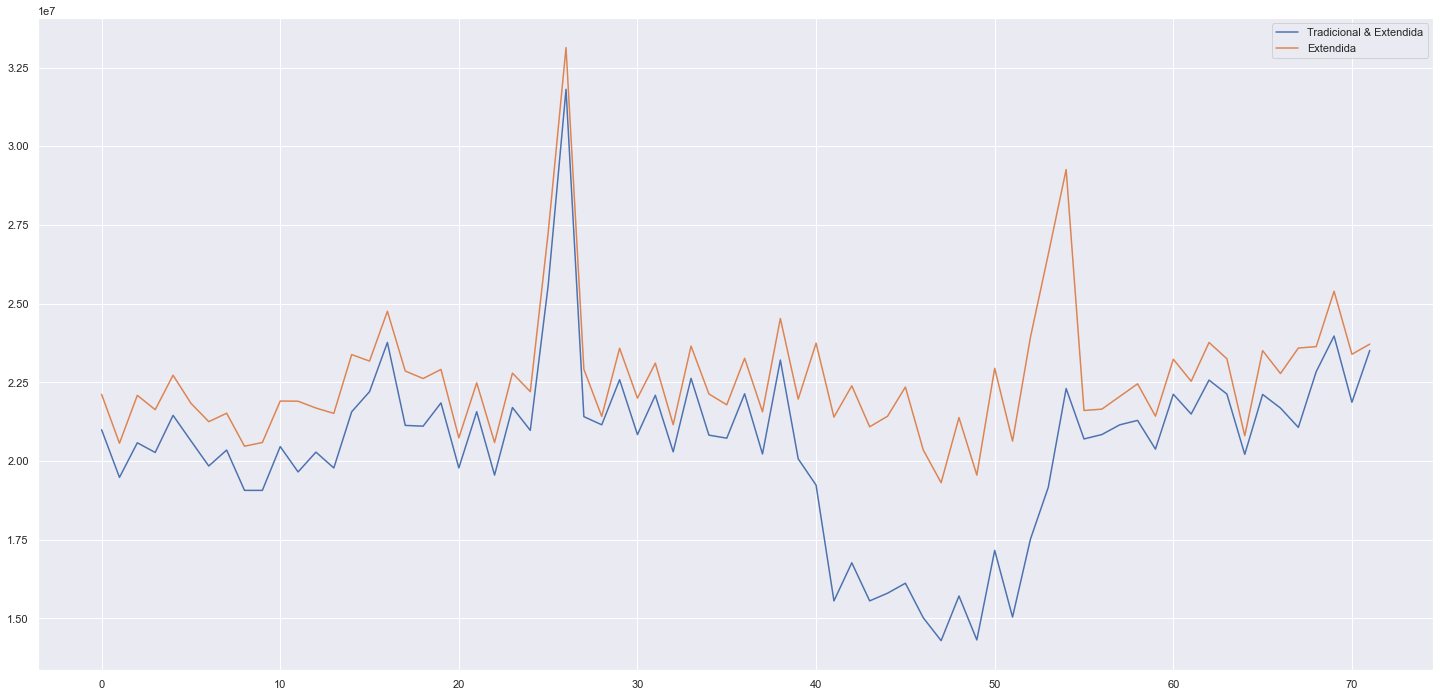

In [35]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### 6.2.6 [H6] Lojas abertas durante o feriado de Natal deveriam vender mais.
#### (FALSA) Lojas abertas durante o feriado do Natal vendem menos.

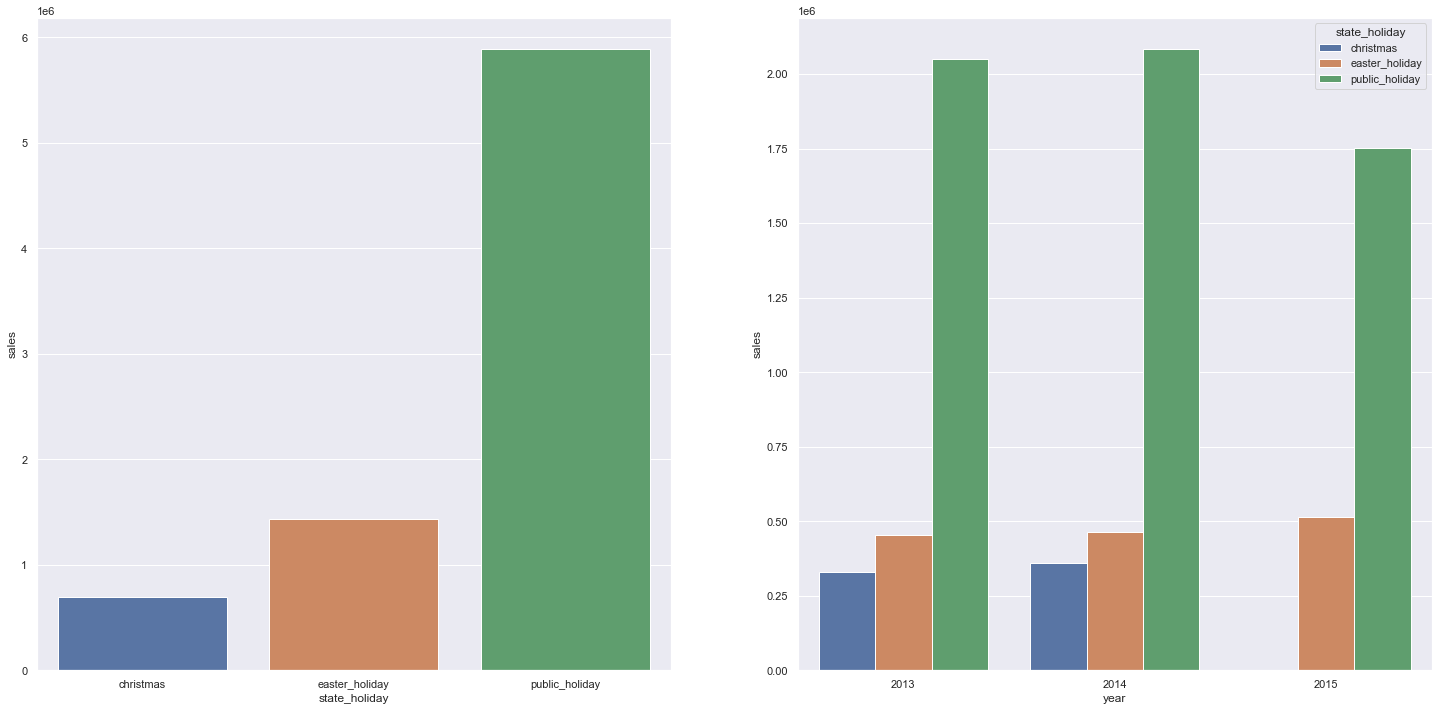

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### 6.2.7 [H7] Lojas deveriam vender mais ao longo dos anos.
#### (FALSA) Lojas vendem menos ao longo dos anos.

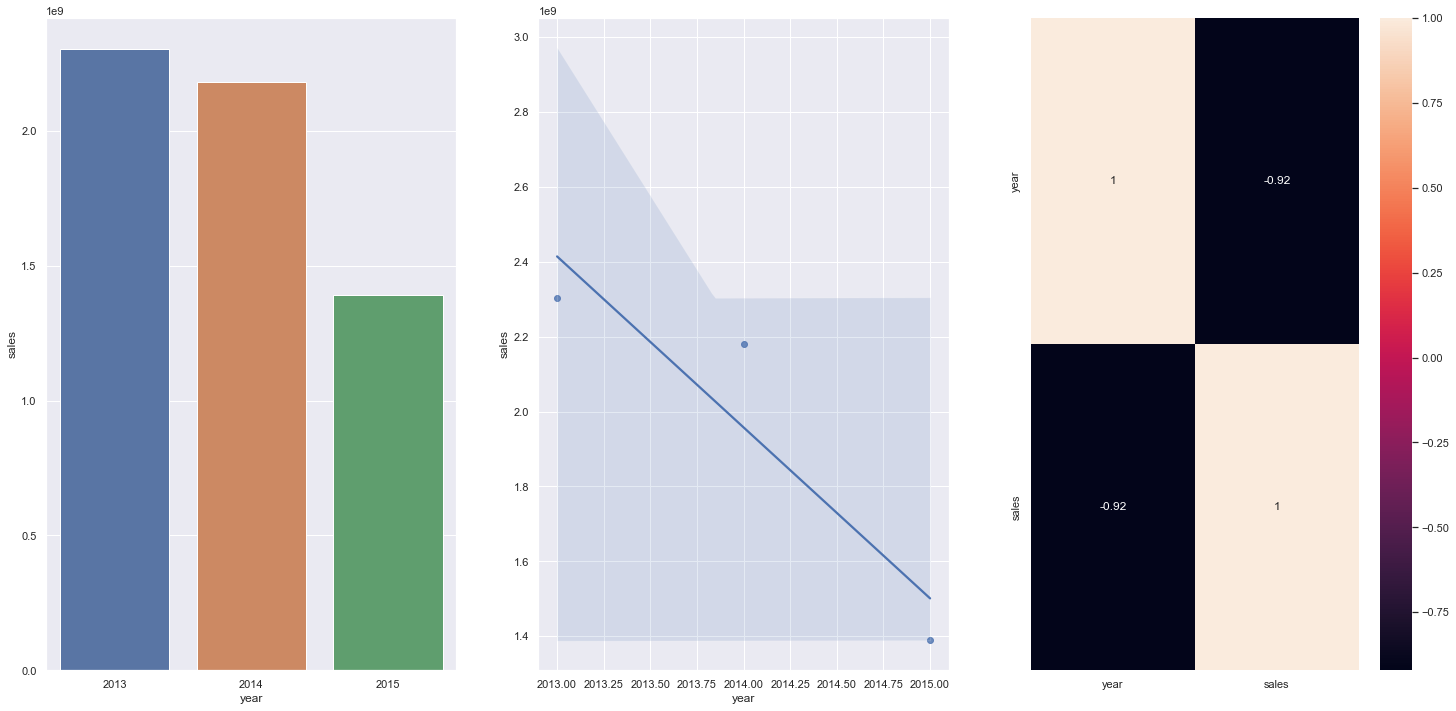

In [37]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 6.2.8 [H8] Lojas deveriam vender mais no segundo semestre do ano.
#### (FALSA) Lojas vendem menos no segundo semestre do ano.

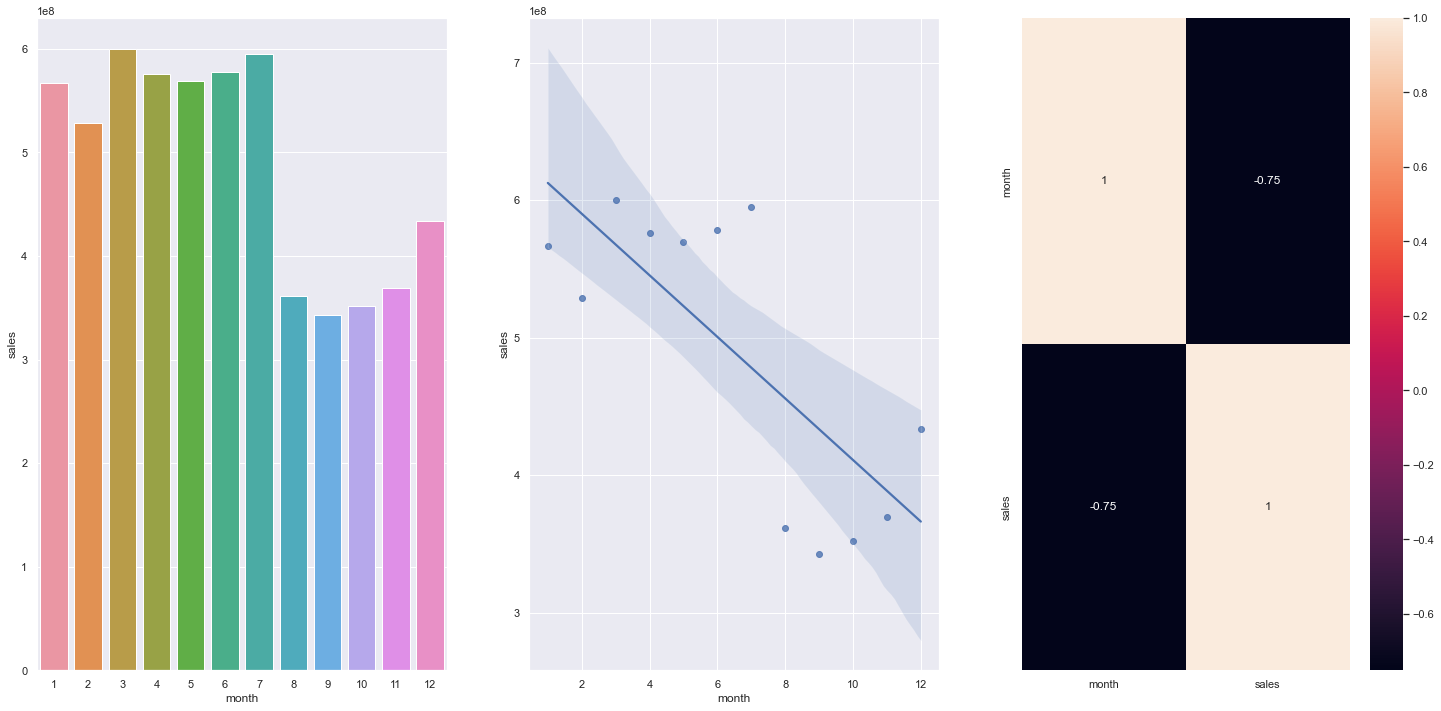

In [38]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 6.2.9 [H9] Lojas deveriam vender mais depois do dia 10 de cada mês.
#### (VERDADEIRA) Lojas vendem mais depois do dia 10 de cada mes.

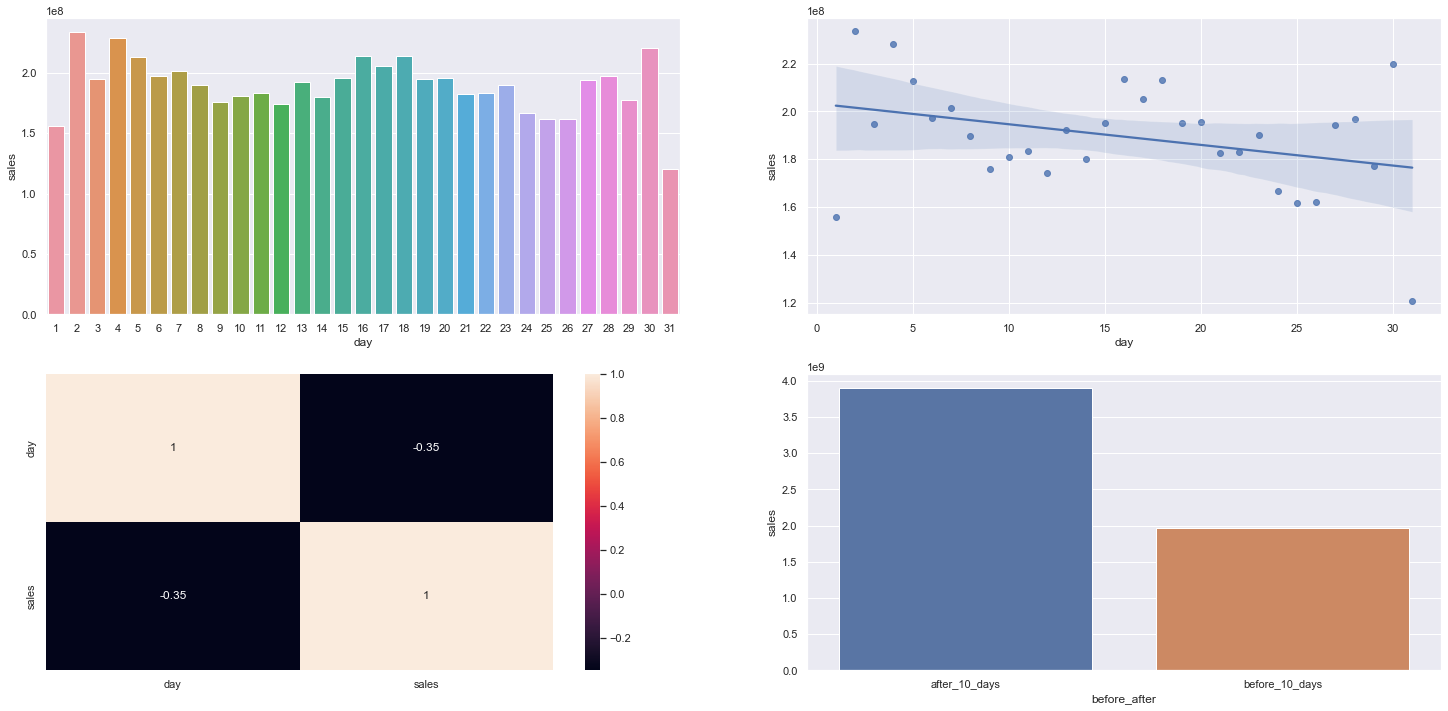

In [39]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### 6.2.10 [H10] Lojas deveriam vender menos aos finais de semana.
#### (VERDADEIRA) Lojas vendem menos nos final de semana.

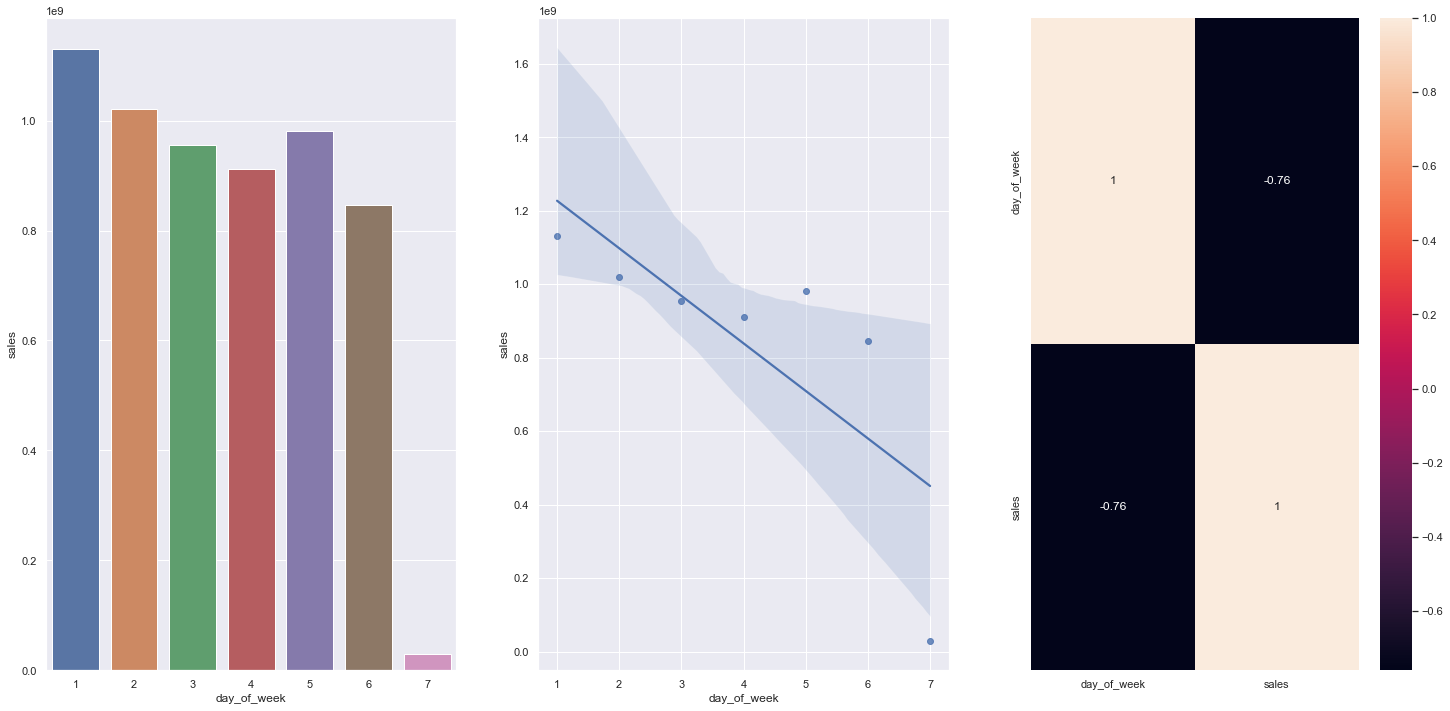

In [40]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 6.2.11 [H11] Lojas deveriam vender menos durante os feriados escolares.
#### (VERDADEIRA) Lojas vendem menos durante os feriadso escolares, exceto os meses de Julho e Agosto

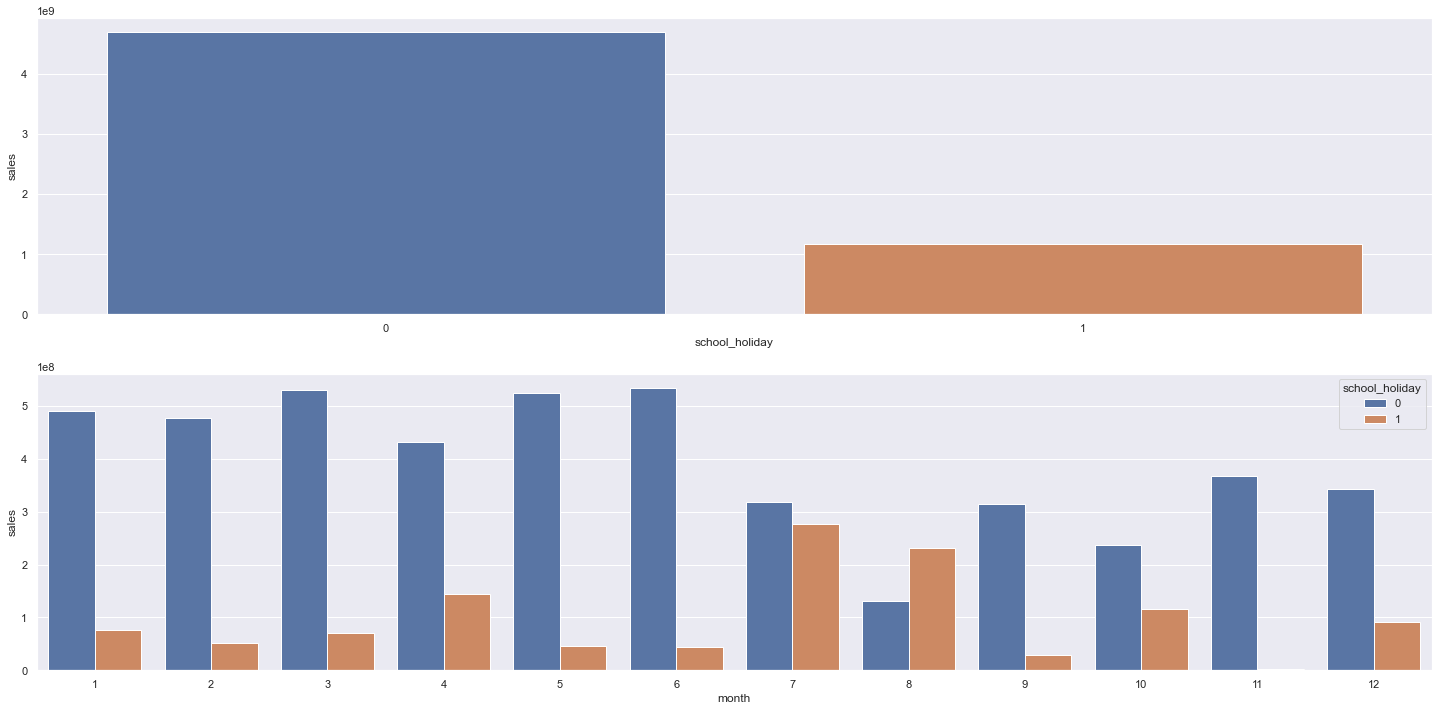

In [41]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 6.2.12 Resumo das Hipoteses

In [42]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', 'Falsa', 'Baixa'],
['H6', 'Falsa', 'Media'],
['H7', 'Falsa', 'Alta'],
['H8', 'Falsa', 'Alta'],
['H9', 'Verdadeira', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           Falsa        Baixa
H6           Falsa        Media
H7           Falsa        Alta
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Baixa


## 6.3 Analise Multivariada

### 6.3.1 Variaveis Numericas

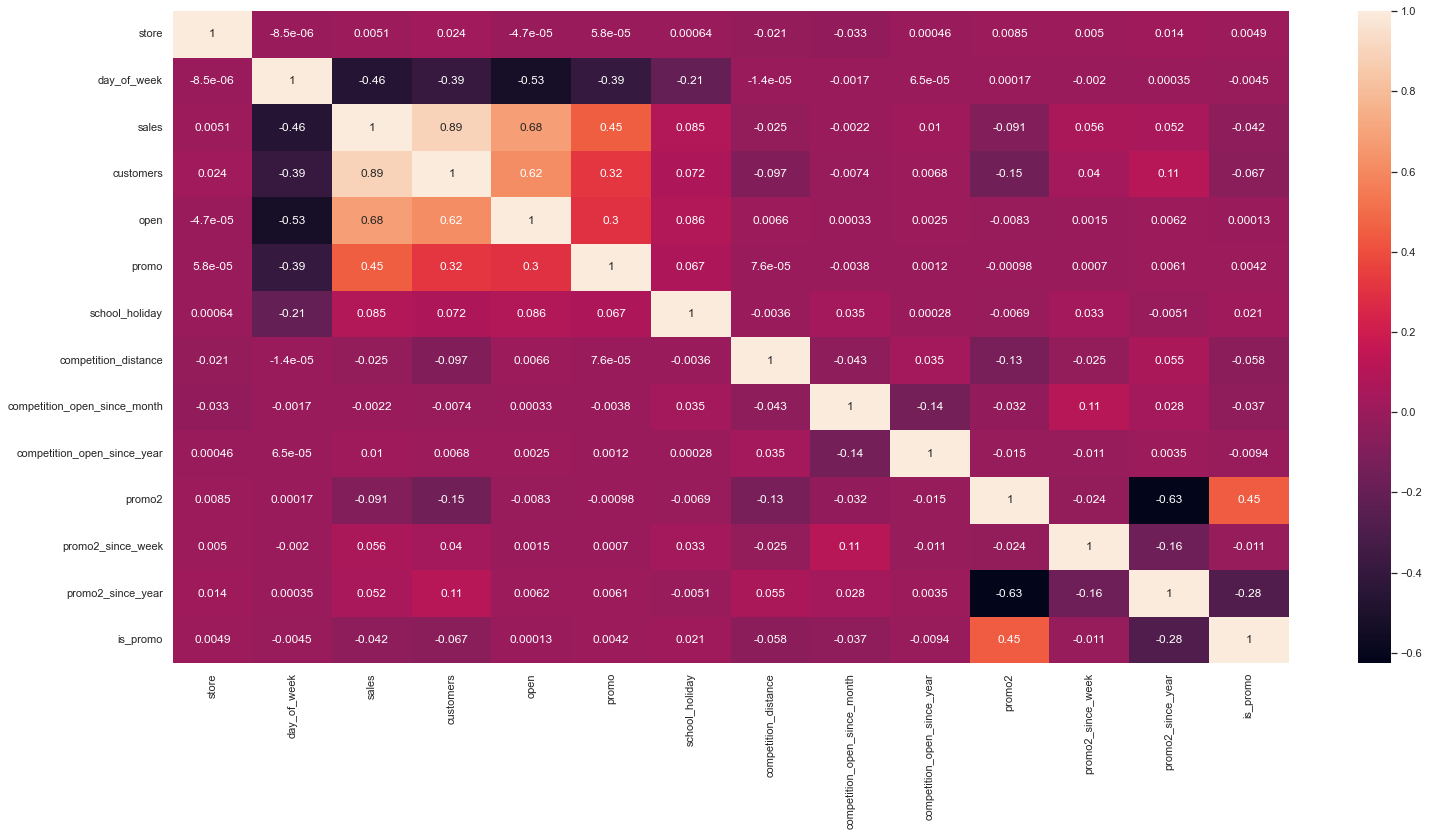

In [43]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 6.3.2 Variaveis Categoricas

<AxesSubplot:>

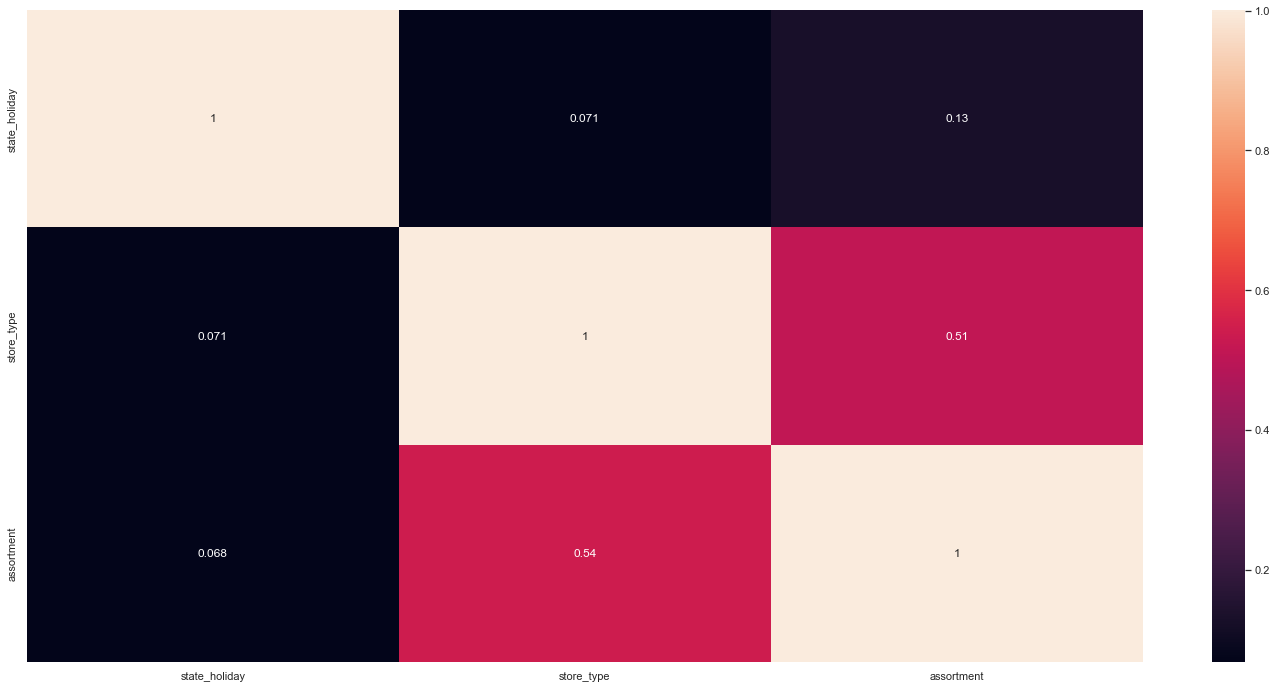

In [44]:
aux = df4[['state_holiday','store_type','assortment']]

# Calculate cramer V
a1 = cramer_v( aux['state_holiday'], aux['state_holiday'] )
a2 = cramer_v( aux['state_holiday'], aux['store_type'] )
a3 = cramer_v( aux['state_holiday'], aux['assortment'] )
a4 = cramer_v( aux['store_type'], aux['state_holiday'] )
a5 = cramer_v( aux['store_type'], aux['store_type'] )
a6 = cramer_v( aux['store_type'], aux['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 7. PREPARACAO DOS DADOS

In [45]:
df5 = df4.copy()

## 7.1 Normalizacao (Standardizing)

## 7.2 Rescalacao (Rescaling)

In [46]:
a = df5.select_dtypes( include=['int32','int64','float64'] )
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


C:\Users\renat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month'>

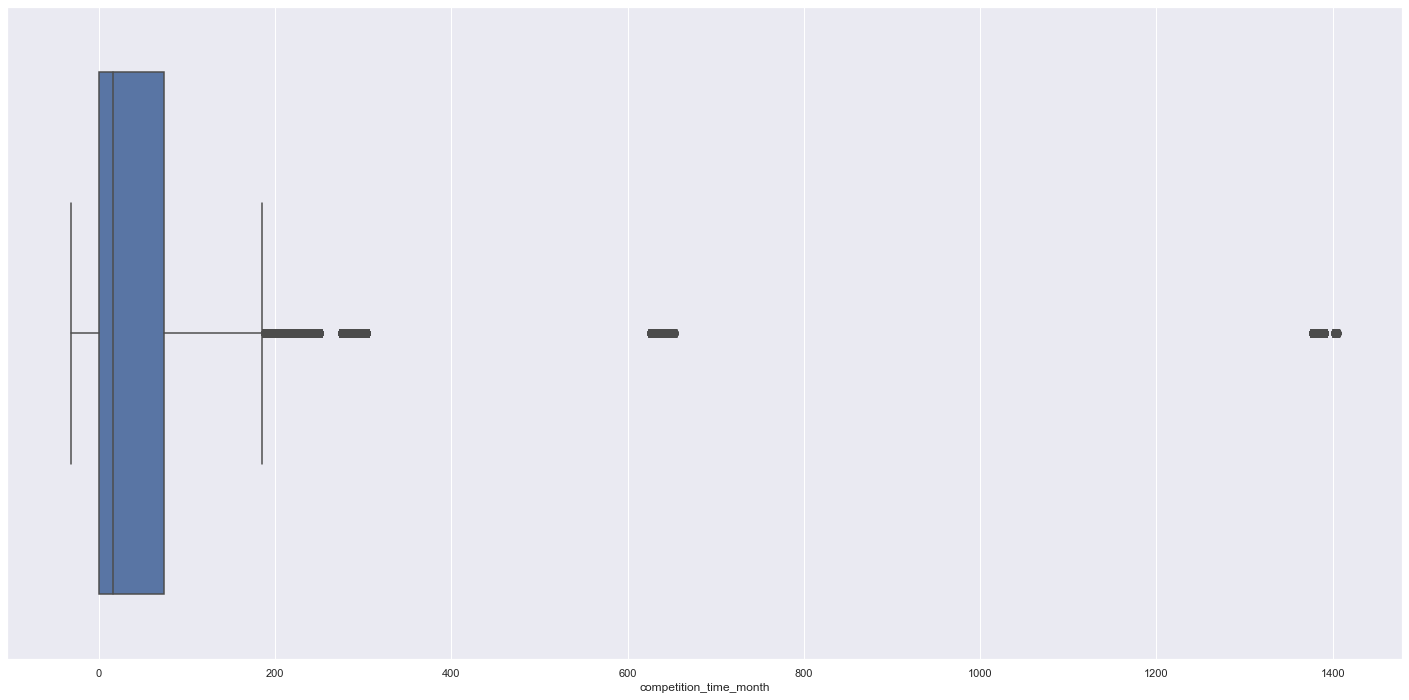

In [47]:
#sns.boxplot( df5['competition_distance'])
sns.boxplot( df5['competition_time_month'])

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 7.3 Tranformacoes

### 7.3.1 Encoding

In [49]:
# One Hot Encoding (state_holiday)
# Cria colunas com as opcoes e seta como 1 na informacao verdadeira.
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# Label Encoding (store_type)
# Enumera as opcoes, independente da relacao entre as opcoes.
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# Ordinal Encoding (assortment)
# Enumera as opcoes, ordenando conforme a relacao entre as opcoes.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

# Target Encoding: utilizada para muitas opcoes categoricas (media de totais da variavel-resposta).
# Frequency Encoding: utilizada para muitas opcoes categoricas (media de qtde da variavel-resposta).

In [52]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 7.3.2 Transformacao da Variavel-Resposta

In [ ]:
# Tipos de Transformacoes de Features
df5['sales'] = np.log1p( df5['sales'] )

### 7.3.3 Transformacao das Naturezas (Transf. Ciclica)

In [53]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2*np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2*np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2*np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2*np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2*np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2*np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2*np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2*np.pi/52 ) ) )

# visualizacao


In [54]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 8. Selecao de Variaveis

## 8.1 Selecao Univariada (Filter Methods)

In [ ]:
# Explicar a porcao que a variavel eh responsavel dentro do fenomero.

## 8.2 Selecao por Importancia (Embedded Methods)

In [ ]:
# Consiste, em metodos embutidos em algoritmos, na separacao de features conforme seu peso, durante o treinamento do modelo.
# Exemplo: modelo Random Forest possui o metodo de importancia que eh chamado "Impureza de Gini"

## 8.3 Selecao por SunSet (Wrapper Methods)

In [ ]:
# utiliza um modelo de aprendizado de máquina para avaliar a importância de cada subconjunto de atributos.
# Selecione uma variavel ---> Treina o modelo ML ---> Calcula a performance --->
# --> A performance aumentou? --Sim-> Mantem a variavel e adiciona outra.
#                             --Nao-> Descarte a variavel e adiciona outra.


## 8.4 Separacao dos Dados para Treino e para Teste

In [65]:
df6 = df5.copy()

In [66]:
# Apagar as colunas originarias de outras features de encoding
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [67]:
# Verificar as datas dos registros para a separacao dos dados de Treino e de Teste
df6[ ['store', 'date']].groupby('store').min().reset_index() # 02/01/2013
df6[ ['store', 'date']].groupby('store').max().reset_index() # 31/05/2015

df6[ ['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7) # 19/06/2015

# Dados para Treino do Dataset
X_train = df6[ df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# Dados para Teste do Dataset
X_test = df6[ df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 8.5 Algoritmo Boruta como Seletor de Feature

In [68]:
# Treino e Teste para o modelo Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Definir RandomForest Regressora
rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


In [69]:
cols_selected = boruta.support_.tolist()

# Melhor variavel
X_train_fs = X_train.drop( ['date','sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Colunas nao selecionadas
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

In [74]:
# Comparacao das colunas apuradas com as hipoteses da alta importancia (Tabela de Hipoteses)
# cols_selected_boruta
# cols_not_selected_boruta
# tab

# Colunas selecionadas por analise
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos'
]
# Adicionar colunas "date" e "sales"
feat_to_add = ['date','sales']
cols_selected_boruta.extend( feat_to_add )

In [75]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

## 8.3 Selecao por SunSet (Wrapper Methods)